In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import numpy as np
import os
from glob import glob

#import climpredNEW.climpred 
#from climpredNEW.climpred.options import OPTIONS
from mpl_toolkits.basemap import Basemap
from numpy import meshgrid
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.colors as mcolors
import cartopy.feature as cfeature
import itertools
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter, LatitudeLocator
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, TwoSlopeNorm
import pandas as pd
import math
from datetime import datetime
import datetime as dt
from multiprocessing import Pool
from sklearn.metrics import confusion_matrix as CM
from scipy import signal
from skimage.metrics import structural_similarity as ssim
import copy
import matplotlib.patches as mpatches

from function import funs as f
from function import caseUtils as cutils
from function import masks
from function import verifications
from function import preprocessUtils as putils
from function import conf
from function import quikplot as qp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#Set script parameters
global region_name, test_year
region_name = 'australia'
test_year = 2019 # [2019,2012]

obs_source = 'GLEAM' #['GLEAM','ERA5']

if obs_source == 'ERA5':
    soil_dir = conf.era_data
elif obs_source == 'GLEAM':
    soil_dir = conf.gleam_data

In [4]:
#For a single week and experiment

global week_lead,day_num
week_lead = 3 #[1,2,3,4,5]
day_num = (week_lead*7) -1

#Reforecast source
source = 'GEFSv12' #['GEFSv12','ECMWF']


global admin_boundaries
admin_boundaries = cfeature.NaturalEarthFeature(category='cultural',
                                                name='admin_1_states_provinces_lines',
                                                scale='50m',
                                                facecolor='none')

In [5]:


assert region_name == 'australia', 'Must be australia for this script since we are setting this as a final figure image'''
assert test_year == 2019, 'Test year must equal 2019'

mask,mask_anom = masks.load_mask_vals(region_name) #Load the mask xarry and mask numpy files. Values of 1 = land 
init_date_list = putils.get_init_date_list(forecast_variable_path=f'{conf.gefsv12_data}/{region_name}/soilw_bgrnd')
start_, end_ = cutils.return_case_study_dates(region_name,test_year)


#Dates for template
global test_start, test_end
if test_year == 2019:
    test_start = '2018-01-01'
    test_end = '2019-12-31'
elif test_year == 2012:
    test_start = '2011-01-01'
    test_end = '2012-12-31'
       


'''LOAD THE DATA'''
global obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only
obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only,ecmwf_bias_corrected,gefs_bias_corrected = cutils.open_obs_and_baseline_files(region_name, week_lead, day_num, start_, end_, mask_anom, test_start, test_end, obs_source, soil_dir)

Loading template data from 2018-01-01 to 2019-12-31
Loading GLEAM, gefsv12 raw reforecast, and ecmwf raw reforecast during case study dates of 2019-09-01 to 2019-10-17


In [6]:

def return_array_anomaly(file,date):
    vals = file.sel(S=date)[putils.xarray_varname(file)].values
    vals[np.isnan(vals)] = 0 #mask ocean values for SSIM
    return(vals)

### Data (loads the observation anomaly, ECWMF, and GEFSv12 anomaly for only the specified dates when looking at the case study.)

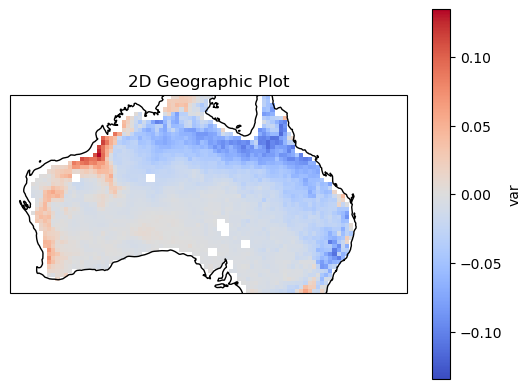

In [7]:
qp.d2_plot(obs_anomaly_SubX_format['var'][0,0,0,:,:])

In [ ]:
def get_min_max_of_files(obs, unet, baseline, ecm, date):
    #test 
    # date = '2019-08-07'
    
    min_ = []
    max_ = []

    min_.append(obs.sel(S=date).min().rci.values)
    min_.append(unet.sel(S=date).min().rci.values)
    min_.append(baseline.sel(S=date).min().rci.values)
    min_.append(ecm.sel(S=date).min().rci.values)
    
    max_.append(obs.sel(S=date).max().rci.values)
    max_.append(unet.sel(S=date).max().rci.values)
    max_.append(baseline.sel(S=date).max().rci.values)
    max_.append(ecm.sel(S=date).max().rci.values)
    
    return(min(min_),max(max_))

def return_array(file,lead,date):
    return(file.sel(L=lead,S=date).rci.values)


def get_min_max_of_files_anomaly(obs, unet, baseline, ecm, init_dates_all):
    #test 
    # date = '2019-08-07'
    
    min_ = []
    max_ = []
    
    for date in init_dates_all:

    
        min_.append(obs.sel(S=date).min()[putils.xarray_varname(obs)].values)
        min_.append(unet.sel(S=date).min()[putils.xarray_varname(unet)].values)
        min_.append(baseline.sel(S=date).min()[putils.xarray_varname(baseline)].values)
        min_.append(ecm.sel(S=date).min()[putils.xarray_varname(ecm)].values)
        
        max_.append(obs.sel(S=date).max()[putils.xarray_varname(obs)].values)
        max_.append(unet.sel(S=date).max()[putils.xarray_varname(unet)].values)
        max_.append(baseline.sel(S=date).max()[putils.xarray_varname(baseline)].values)
        max_.append(ecm.sel(S=date).max()[putils.xarray_varname(ecm)].values)
    
    return(min(min_),max(max_))

def return_plot_info(region_name):

    if region_name == 'australia':
        text_x = 134
        text_y = -30
        fig_width = 8
        fig_height = 8
    

    font_size_corr = 7
    return(text_x, text_y, fig_width, fig_height, font_size_corr)

In [ ]:

def return_bbox(ref_to_plot_for_region,region_name,plot_models):
    obss = plot_models[0]
    if region_name == 'australia':
        if pd.to_datetime(ref_to_plot_for_region.S.values[0]).year == 2019:
            #I had to manually figure out these things for the greeen colored study bbox. 
            v1,v2,widt,heigt = 140, ref_to_plot_for_region.Y.values[-2],14,10
            ref_bbox = ref_to_plot_for_region.sel(Y=slice(v2+heigt,v2)).sel(X=slice(v1,v1+widt))
            obs_bbox = obss.sel(Y=slice(v2+heigt,v2)).sel(X=slice(v1,v1+widt))
    elif region_name == 'china':
        if pd.to_datetime(ref_to_plot_for_region.S.values[0]).year == 2019:
            v1,v2,widt,heigt = 100, 23, 21, 15
            ref_bbox = ref_to_plot_for_region.sel(Y=slice(v2+heigt,v2)).sel(X=slice(v1,v1+widt))
            obs_bbox = obss.sel(Y=slice(v2+heigt,v2)).sel(X=slice(v1,v1+widt))
    elif region_name == 'CONUS':
        if pd.to_datetime(ref_to_plot_for_region.S.values[0]).year == 2019:
            v1,v2,widt,heigt = -92, 30.5, rightlon-leftlon, toplat-btmlat
        elif pd.to_datetime(ref_to_plot_for_region.S.values[0]).year == 2012:
            v1,v2,widt,heigt = leftlon-360, btmlat-1, 20, 12
        ref_bbox = ref_to_plot_for_region.sel(Y=slice(v2+heigt,v2)).sel(X=slice(v1+360,v1+widt+360))
        obs_bbox = obss.sel(Y=slice(v2+heigt,v2)).sel(X=slice(v1+360,v1+widt+360)) 

    return(ref_bbox, obs_bbox, v1,v2,widt,heigt)

In [ ]:
# cmap = 'coolwarm'
def plot_case_study_anomaly(obs, unet, baseline, ecm, leftlon, rightlon, toplat, btmlat, obs_source):
    
    lon = obs.X.values
    lat = obs.Y.values
        
    plot_model_names = [obs_source,'DL_NWP_OBS','GEFSv12-BC','ECMWF-BC']
    plot_models = [obs, unet, baseline, ecm]

    text_x, text_y, fig_width, fig_height, font_size_corr = return_plot_info(region_name)

    cmap = plt.get_cmap('bwr_r')    
    
    save_dir = f'Outputs/Case_studies/test_other_models/{region_name}/Wk{week_lead}'
    os.system(f'mkdir -p {save_dir}')
        
    fig, axs = plt.subplots(
        nrows = len(obs.S.values), ncols= len(plot_models), subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(fig_width,fig_height),
    layout="constrained")
    
    axs = axs.flatten()
    
    min_,max_ = get_min_max_of_files_anomaly(obs, unet, baseline, ecm, obs.S.values)
    min_,max_ = -0.1,0.1
    
    v = np.linspace(min_, max_, 20, endpoint=True)
    #Make sure we have a diverging color at 0
    v  = [i for i in v if i <0] + [0] + [i for i in v if i >0]

    axs_start = 0
    for init_date in obs.S.values:
        #for testing
        # init_date = obs.S.values[0]
        # lead = day_num
        # data_to_plot = plot_models[2]
        # name = plot_model_names[2]
        
        init_date = pd.to_datetime(init_date)
        date = f'{init_date.year}-{init_date.month:02}-{init_date.day:02}'
        # break
        for lead in [day_num]:
            for data_to_plot,name in zip(plot_models, plot_model_names):
                # print(data_to_plot)
                # break
                # if name == 'DL_NWP_OBS':
                    # break
                ref_to_plot_for_region = data_to_plot


                data = return_array_anomaly(file=data_to_plot, date=init_date)

                if region_name == 'CONUS':
                    map = Basemap(projection='cyl', llcrnrlat=btmlat, urcrnrlat=toplat,
                                  llcrnrlon=leftlon-360, urcrnrlon=rightlon-360, resolution='l')
                elif region_name == 'australia':
                    map = Basemap(projection='cyl', llcrnrlat=-37, urcrnrlat=-12,
                                  llcrnrlon=110, urcrnrlon=160, resolution='l')
                elif region_name == 'china':
                    map = Basemap(projection='cyl', llcrnrlat=20.5, urcrnrlat=44,
                                  llcrnrlon=74.5, urcrnrlon=122, resolution='l')
                    
                x, y = map(*np.meshgrid(lon, lat))
                # Adjust the text coordinates based on the actual data coordinates
                norm = TwoSlopeNorm(vmin=min_, vcenter=0, vmax=max_)
                im = axs[axs_start].contourf(x, y, np.where(np.isnan(mask_anom), np.nan, data), levels=v, extend='both',
                                      transform=ccrs.PlateCarree(), cmap=cmap,norm=norm)
                
                # Correct usage of Rectangle to add a box. Assume leftlon, rightlon, toplat, btmlat are defined as per your code.

                ref_bbox, obs_bbox, v1,v2,widt,heigt = return_bbox(ref_to_plot_for_region,region_name, plot_models)
                rect = mpatches.Rectangle((v1, v2), widt, heigt,
                                      edgecolor='gold', facecolor='none', transform=ccrs.PlateCarree(), linewidth =3)
                axs[axs_start].add_patch(rect)
                # gl = axs[axs_start].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                #                            linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
                # gl.top_labels = False
                # gl.right_labels = False
                # if lead != 1:
                #     gl.left_labels = False
                # gl.xformatter = LongitudeFormatter()
                # gl.yformatter = LatitudeFormatter()
                
                axs[axs_start].coastlines()
                axs[axs_start].add_feature(admin_boundaries, edgecolor='black') #Country/state/province divisions
                
                # plt.colorbar(im)
                # axs[idx].set_aspect('auto', adjustable=None)
                axs[axs_start].set_aspect('equal')  # this makes the plots better
                
                '''Add date the top of the first plot'''
                if axs_start <=len(plot_models)-1:
                    if name == 'DL_NWP_OBS':
                        exp_split = exp.split('_')[0]
                        if 'EX24' in exp:
                            tit_ = f"{exp_split[0:2]}P{exp_split[2:]}_OBS"
                        else:
                            tit_ = f"{exp_split[0:2]}P{exp_split[2:]}_GEFSv12"
                    else:
                        tit_ = name
                
                    axs[axs_start].set_title(f'{tit_} ',fontsize=12)

                if axs_start %4 == 0:
                    # print(f"Condition met for axs_start={axs_start}, setting ylabel")
                    # axs[axs_start].set_ylabel(f'Init\n{date}',fontsize=22, labelpad=10)
                    axs[axs_start].text(-0.48, 0.5, f'       Init\n{date}', va='center', ha='left', rotation='horizontal', fontsize=10, transform=axs[axs_start].transAxes)
    
                if name in ['DL_NWP_OBS','GEFSv12-BC', 'ECMWF-BC']:
                    # Calculate the Pearson correlation coefficient
                    ref_subset = ref_bbox[putils.xarray_varname(ref_bbox)].sel(S=init_date).values
                    ref_subset = np.where(np.isnan(ref_subset),0,ref_subset)
                    
                    obs_subset = obs_bbox[putils.xarray_varname(obs_bbox)].sel(S=init_date).values
                    obs_subset = np.where(np.isnan(obs_subset),0,obs_subset)

                    obs_flat = obs_subset.flatten()
                    data_flat = ref_subset.flatten()
                    
                    data_range = max(np.nanmax(obs_flat), np.nanmax(data_flat)) - min(np.nanmin(obs_flat), np.nanmin(data_flat))
                    ssim_index, _ = ssim(obs_subset, ref_subset, full=True, data_range=data_range)

                    # Now calculate SSIM
                    ssim_index = np.abs(ssim_index)
                    rmse = np.nanmean((obs_subset - ref_subset)**2)
                    mae =  np.nanmean(np.abs(obs_subset - ref_subset))
                    
                    if name != 'ECMWF':
                        data_flat = data_flat[~np.isnan(obs_flat)]
                        np.count_nonzero(np.isnan(data_flat))

                        obs_flat = obs_flat[~np.isnan(obs_flat)]
                        np.count_nonzero(np.isnan(obs_flat))
                    else:
                        good_ref_values = [idx for (idx,i) in enumerate(data_flat) if ~np.isnan(i)]
                        data_flat = data_flat[good_ref_values]
                        obs_flat=obs_flat[good_ref_values]
                        np.count_nonzero(np.isnan(obs_flat))
                        #Now only grab the indices from obs which have values
                        obs_good_values = ~np.isnan(obs_flat)
                        data_flat = data_flat[obs_good_values]
                        obs_corr = obs_flat[obs_good_values]
                        
                    correlation_matrix = np.corrcoef(obs_flat, data_flat)
                    # The correlation coefficient is in the top right corner of the correlation matrix
                    correlation_coefficient = correlation_matrix[0, 1]
                    correlation_coefficient = round(correlation_coefficient,4)
                    
                    #find the correlation coefficient across the dataset
                    '''With MAE'''
                    axs[axs_start].text(text_x, text_y, f'MAE: {str(mae)[1:5]}\nSSIM: {str(ssim_index)[1:5]}\nr: {str(correlation_coefficient)[1:5]}', ha='right', va='bottom', 
                    fontsize=font_size_corr, color='black', 
                           bbox=dict(facecolor='white', alpha=1, edgecolor='none', boxstyle='round',pad=0.5))
                         
                
                axs_start+=1

    #                      [left, bottom, width, height] 
    cbar_ax = fig.add_axes([0.12, -0.02, .85, .02])
    
    # Draw the colorbar
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
    cbar.set_label('Anomaly (m3/m3)')
    # fig.suptitle(f'Week {week_lead}', fontsize=15)
    # plt.tight_layout()
    
    plt.savefig(f'{save_dir}/{exp}_{region_name}_{pd.to_datetime(start_).year}_{obs_source}.png',bbox_inches='tight')
    plt.show()

In [ ]:
def make_plot_by_experiment_name_with_boundary_box(exp, mean_or_median,obs_source):

    #Look at a single plot
    unet_anomaly = verifications.create_reforecast_with_predictions_single_lead(template_testing_only = template_testing_only, day_num=day_num, week_lead=week_lead, 
                                                                                experiment_name=exp, region_name=region_name, mask_anom = mask_anom,
                                                                               start_ = start_, end_ = end_, source = source, test_year = test_year,
                                                                               obs_source=obs_source)
     
    '''check the mask values'''
    if np.count_nonzero(np.isnan(mask_anom)) >=1:
        nan=True
    else:
        nan=False

    # Mask data to LAND
    if region_name == 'CONUS':
        if mean_or_median == 'mean':
            obs = xr.where(mask_anom ==1, obs_anomaly_SubX_format.sel(L=day_num).mean(dim='M').sel(S=slice(start_,end_)),np.nan)
            unet = xr.where(mask_anom ==1, unet_anomaly.mean(dim='M'),np.nan)
            baseline = xr.where(mask_anom ==1, gefs_bias_corrected.mean(dim='M').sel(L=day_num).sel(S=slice(start_,end_)),np.nan)
            ecm = xr.where(mask_anom ==1, ecmwf_bias_corrected.mean(dim='M').sel(L=day_num).sel(S=slice(start_,end_)),np.nan)
        else:
            
            obs = xr.where(mask_anom ==1, obs_anomaly_SubX_format.sel(L=day_num).median(dim='M').sel(S=slice(start_,end_)),np.nan)
            unet = xr.where(mask_anom ==1, unet_anomaly.median(dim='M'),np.nan)
            baseline = xr.where(mask_anom ==1, gefs_bias_corrected.median(dim='M').sel(L=day_num).sel(S=slice(start_,end_)),np.nan)
            ecm = xr.where(mask_anom ==1, ecmwf_bias_corrected.median(dim='M').sel(L=day_num).sel(S=slice(start_,end_)),np.nan)
    else:

        obs = xr.where(np.isnan(mask_anom), np.nan, obs_anomaly_SubX_format.sel(L=day_num).mean(dim='M').sel(S=slice(start_,end_)))
        unet = xr.where(np.isnan(mask_anom), np.nan, unet_anomaly.mean(dim='M'))
        baseline = xr.where(np.isnan(mask_anom), np.nan, gefs_bias_corrected.mean(dim='M').sel(L=day_num).sel(S=slice(start_,end_)))
        ecm = xr.where(np.isnan(mask_anom), np.nan, ecmwf_bias_corrected.mean(dim='M').sel(L=day_num).sel(S=slice(start_,end_)))
        unet = xr.where(unet[putils.xarray_varname(unet)]<=unet_anomaly[putils.xarray_varname(unet_anomaly)].min().values,np.nan,unet)
    
    dates_ = obs.S.values
    unet = unet.assign_coords({'S':dates_})
    baseline = baseline.assign_coords({'S':dates_})
    ecm = ecm.assign_coords({'S':dates_})
    

    if region_name == 'CONUS':
        if pd.to_datetime(start_).year == 2012:
            leftlon, rightlon, toplat, btmlat = 259, 275, 47, 35
        elif pd.to_datetime(start_).year == 2019:
            leftlon, rightlon, toplat, btmlat = 268, 283, 39, 30.5 #This isn't fully tested yet
    else:
        if pd.to_datetime(start_).year == 2019:
            leftlon, rightlon, toplat, btmlat = unet.X.values[0], unet.X.values[-1], unet.Y.values[0], unet.Y.values[-1]

    #Call plot function
    plot_case_study_anomaly(obs=obs, unet=unet, baseline=baseline,
                            leftlon=leftlon, rightlon=rightlon, toplat=toplat, btmlat=btmlat, ecm=ecm,obs_source=obs_source)

In [ ]:
if obs_source=='GLEAM':
    exp = 'EX29_regular_RZSM' #DO NOT CHANGE
else:
    exp = 'EX29_regular_ERA5_RZSM' #DO NOT CHANGE


if test_year == 2019:
    make_plot_by_experiment_name_with_boundary_box(exp=exp, mean_or_median='mean',obs_source=obs_source)
elif test_year == 2012:
    exp = f'{exp}_{test_year}'
    make_plot_by_experiment_name_with_boundary_box(exp=exp, mean_or_median='mean', obs_source=obs_source)

In [ ]:
stop

In [ ]:
t

In [ ]:
def make_plot_by_experiment_name_just_single_area(exp, mean_or_median):


    #Look at a single plot
    unet_anomaly = verifications.create_reforecast_with_predictions_single_lead(template_testing_only = template_testing_only, day_num=day_num, week_lead=week_lead, 
                                                                                experiment_name=exp, region_name=region_name, mask_anom = mask_anom,
                                                                               start_ = start_, end_ = end_, source = source, test_year = test_year)
    
    # Mask data to LAND
    if region_name == 'CONUS':
        if mean_or_median == 'mean':
            obs = xr.where(mask_anom ==1, obs_anomaly_SubX_format.sel(L=day_num).mean(dim='M').sel(S=slice(start_,end_)),np.nan)
            unet = xr.where(mask_anom ==1, unet_anomaly.mean(dim='M'),np.nan)
            baseline = xr.where(mask_anom ==1, baseline_anomaly.mean(dim='M').sel(L=day_num).sel(S=slice(start_,end_)),np.nan)
            ecm = xr.where(mask_anom ==1, baseline_ecmwf.mean(dim='M').sel(L=day_num).sel(S=slice(start_,end_)),np.nan)
        else:
            obs = xr.where(mask_anom ==1, obs_anomaly_SubX_format.sel(L=day_num).median(dim='M').sel(S=slice(start_,end_)),np.nan)
            unet = xr.where(mask_anom ==1, unet_anomaly.median(dim='M'),np.nan)
            baseline = xr.where(mask_anom ==1, baseline_anomaly.median(dim='M').sel(L=day_num).sel(S=slice(start_,end_)),np.nan)
            ecm = xr.where(mask_anom ==1, baseline_ecmwf.median(dim='M').sel(L=day_num).sel(S=slice(start_,end_)),np.nan)
            
    elif region_name == 'australia':
        obs = xr.where(np.isnan(mask_anom), np.nan, obs_anomaly_SubX_format.sel(L=day_num).mean(dim='M').sel(S=slice(start_,end_)))
        unet = xr.where(np.isnan(mask_anom), np.nan, unet_anomaly.mean(dim='M'))
        baseline = xr.where(np.isnan(mask_anom), np.nan, baseline_anomaly.mean(dim='M').sel(L=day_num).sel(S=slice(start_,end_)))
        ecm = xr.where(np.isnan(mask_anom), np.nan, baseline_ecmwf.mean(dim='M').sel(L=day_num).sel(S=slice(start_,end_)))
        
    dates_ = obs.S.values
    unet = unet.assign_coords({'S':dates_})
    baseline = baseline.assign_coords({'S':dates_})
    ecm = ecm.assign_coords({'S':dates_})
    
    
    
    
       
    # cmap = 'coolwarm'
    def plot_case_study_anomaly(obs, unet, baseline, ecm):

        if region_name == 'CONUS':
            text_x = -83.5
            text_y = 27
            fig_width = 10
            fig_height = 15
        elif region_name == 'australia':
            text_x = 136
            text_y = -36
            fig_width = 10
            fig_height = 30
            
        font_size_corr = 9
        
        cmap = plt.get_cmap('bwr')    
        
        save_dir = f'timeseries/Outputs/Case_studies/test_other_models/{region_name}/Wk{week_lead}'
        os.system(f'mkdir -p {save_dir}')
            
        fig, axs = plt.subplots(
            nrows = len(obs.S.values), ncols= 4, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(fig_width,fig_height))
        axs = axs.flatten()
        
        
        min_,max_ = get_min_max_of_files_anomaly(obs, unet, baseline, ecm, obs.S.values)
        v = np.linspace(min_, max_, 20, endpoint=True)
        #Make sure we have a diverging color at 0
        v  = [i for i in v if i <0] + [0] + [i for i in v if i >0]

        
        # test_file = mae_rzsm_keys
        # for Subx original data
    
        # min_,max_ = -0.5,1
        
        lon = obs.X.values
        lat = obs.Y.values
        
        axs_start = 0
        for init_date in obs.S.values:
            init_date = pd.to_datetime(init_date)
            date = f'{init_date.year}-{init_date.month:02}-{init_date.day:02}'
            # break
            for lead in [day_num]:
                for data_to_plot,name in zip([obs, unet, baseline, ecm], ['GLEAM','UNET','GEFSv12', 'ECMWF']):
                    # break
                    data = return_array_anomaly(file=data_to_plot, date=init_date)

                    if region_name == 'CONUS':
                        map = Basemap(projection='cyl', llcrnrlat=25, urcrnrlat=50,
                                      llcrnrlon=-128, urcrnrlon=-60, resolution='l')
                    elif region_name == 'australia':
                        map = Basemap(projection='cyl', llcrnrlat=-37, urcrnrlat=-12,
                                      llcrnrlon=110, urcrnrlon=160, resolution='l')
                        
                    x, y = map(*np.meshgrid(lon, lat))
                    # Adjust the text coordinates based on the actual data coordinates
                
                    norm = TwoSlopeNorm(vmin=min_, vcenter=0, vmax=max_)
                
                    im = axs[axs_start].contourf(x, y, data, levels=v, extend='both',
                                          transform=ccrs.PlateCarree(), cmap=cmap,norm=norm)
            
            
                    # axs[idx].title.set_text(f'SubX Lead {lead*7}')
                    gl = axs[axs_start].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                               linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
                    gl.top_labels = False
                    gl.right_labels = False
                    if lead != 1:
                        gl.left_labels = False
                    gl.xformatter = LongitudeFormatter()
                    gl.yformatter = LatitudeFormatter()
                    axs[axs_start].coastlines()
                    # plt.colorbar(im)
                    # axs[idx].set_aspect('auto', adjustable=None)
                    axs[axs_start].set_aspect('equal')  # this makes the plots better
                    axs[axs_start].set_title(f'{name} \nLead {lead} Init: {date} ',fontsize=12)
        
                    if name in ['UNET','GEFSv12', 'ECMWF']:
                        # Calculate the Pearson correlation coefficient
                        obs_corr = return_array_anomaly(file=obs, date=init_date).flatten()
                        data_corr = data.flatten()

                        if name != 'ECMWF':
                            data_corr = data_corr[~np.isnan(obs_corr)]
                            np.count_nonzero(np.isnan(data_corr))
    
                            obs_corr = obs_corr[~np.isnan(obs_corr)]
                            np.count_nonzero(np.isnan(obs_corr))
                        else:
                            good_ref_values = [idx for (idx,i) in enumerate(data_corr) if ~np.isnan(i)]
                            data_corr = data_corr[good_ref_values]
                            obs_corr=obs_corr[good_ref_values]
                            np.count_nonzero(np.isnan(obs_corr))
                            #Now only grab the indices from obs which have values
                            obs_good_values = ~np.isnan(obs_corr)
                            data_corr = data_corr[obs_good_values]
                            obs_corr = obs_corr[obs_good_values]
                            
                        
                            
                        correlation_matrix = np.corrcoef(obs_corr, data_corr)
                        # The correlation coefficient is in the top right corner of the correlation matrix
                        correlation_coefficient = correlation_matrix[0, 1]
                        correlation_coefficient = round(correlation_coefficient,4)
                        #find the correlation coefficient across the dataset
                        axs[axs_start].text(text_x, text_y, f'Corr: {correlation_coefficient}', ha='right', va='bottom', fontsize=font_size_corr, color='blue', weight = 'bold')
                    
                    
                    axs_start+=1
                
        cbar_ax = fig.add_axes([0.05, -0.05, .9, .04])
        
        # Draw the colorbar
        cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
        fig.suptitle(f'{exp}', fontsize=30)
        fig.tight_layout()
        
        plt.savefig(f'{save_dir}/{exp}_.png',bbox_inches='tight')
        plt.show()

    #Call plot function
    plot_case_study_anomaly(obs=obs, unet=unet, baseline=baseline, obs_source=obs_source)